In [1]:
!pip install -U imbalanced-learn==0.10.1 scikit-learn==1.2.2 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.6 MB/s eta 0:00:00


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocssing

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

df = pd.read_csv("/kaggle/input/healthcare-stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
df.fillna({'bmi': df['bmi'].median()}, inplace=True)

In [8]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [9]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

negative_values = (df[numerical_columns] < 0).sum()

print(negative_values)

id                   0
age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
stroke               0
dtype: int64


In [10]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('stroke')

# Calculate IQR for outlier removal
# Calculate Q1, Q3, and IQR for each numerical column
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds for each numerical column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a condition to detect outliers
outliers_condition = ((df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound))

# Get the number of outliers in each column
outliers_count = outliers_condition.sum()

# Display the count of outliers in each column
print(outliers_count)


id                     0
age                    0
hypertension         498
heart_disease        276
avg_glucose_level    627
bmi                  126
dtype: int64


In [11]:
df_no_outliers = df[~outliers_condition.any(axis=1)]

print(f"Original shape: {df.shape}")
print(f"Shape after removing outliers: {df_no_outliers.shape}")

df_no_outliers.head()

Original shape: (5110, 12)
Shape after removing outliers: (3926, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,28.1,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
12,12175,Female,54.0,0,0,Yes,Private,Urban,104.51,27.3,smokes,1
18,27458,Female,60.0,0,0,No,Private,Urban,89.22,37.8,never smoked,1


In [12]:
# Reassign the data to a new variable name
df = df_no_outliers

Categorical variables:
Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')
Numerical variables:
['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
id
Skew:  -0.03


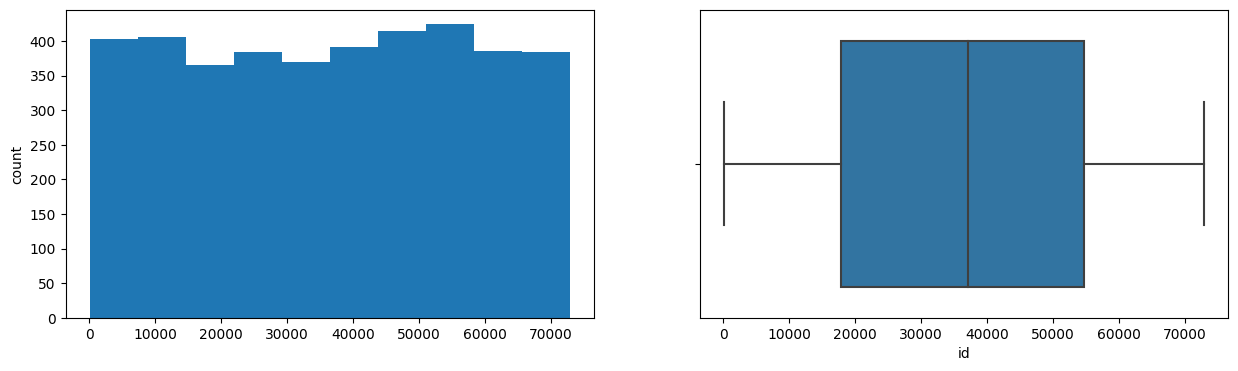

age
Skew:  0.09


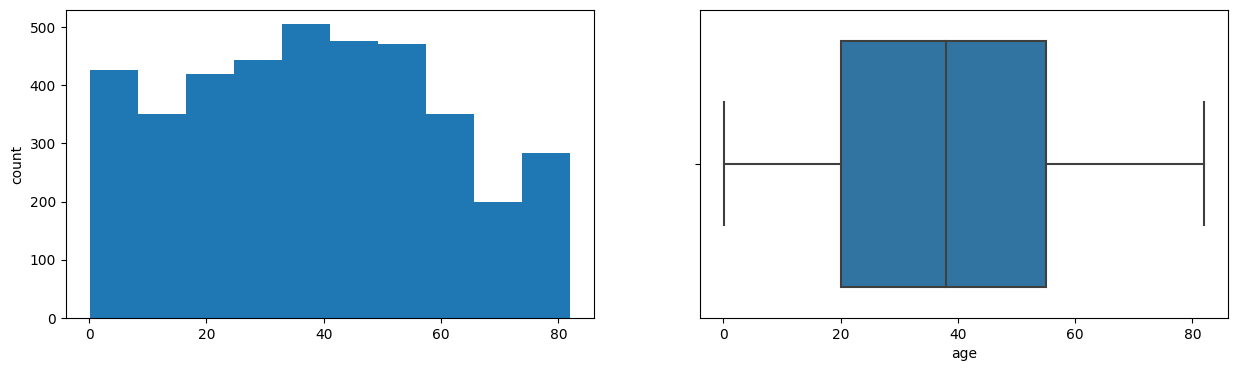

hypertension
Skew:  0.0


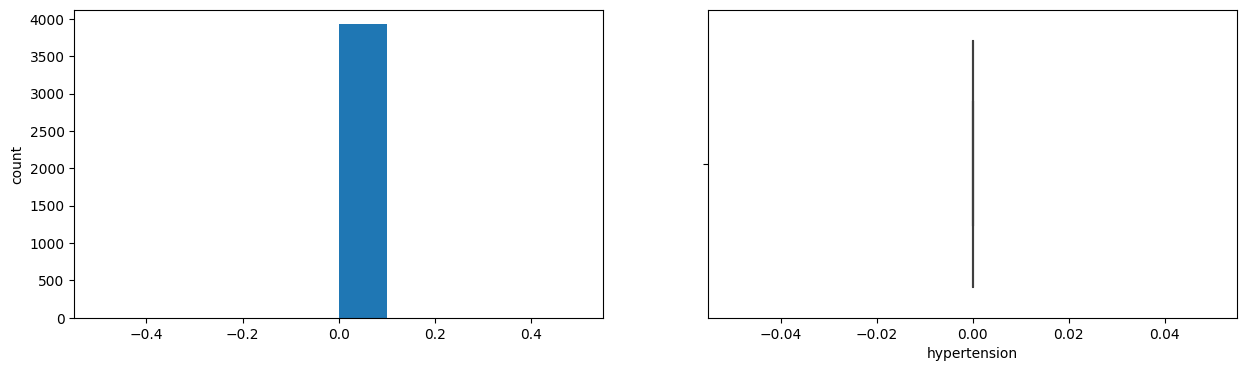

heart_disease
Skew:  0.0


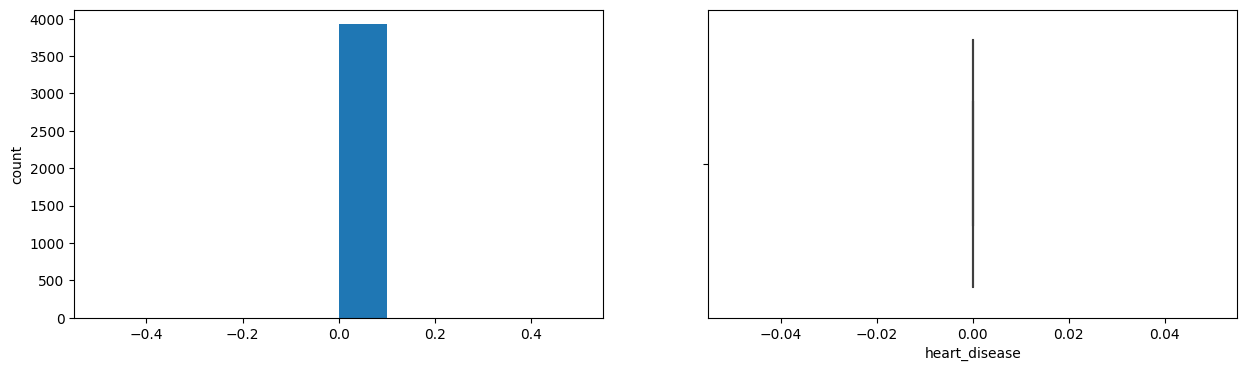

avg_glucose_level
Skew:  0.86


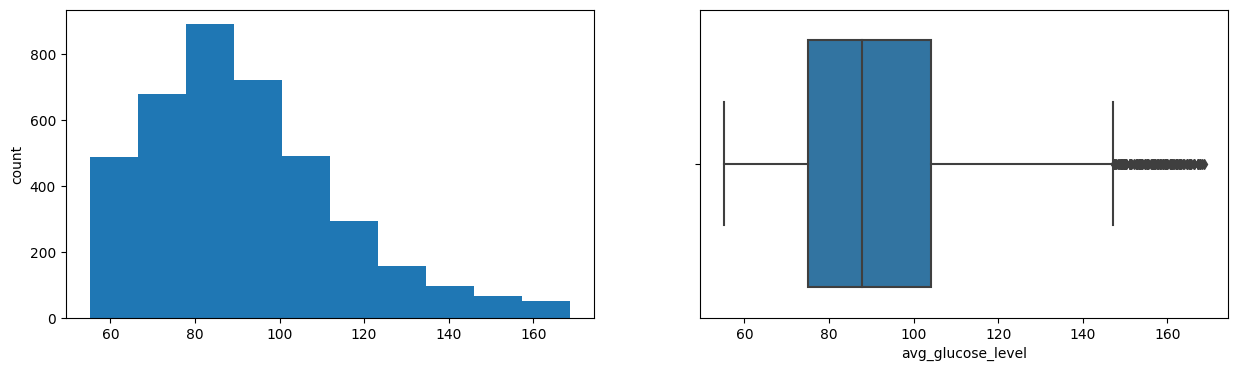

bmi
Skew:  0.36


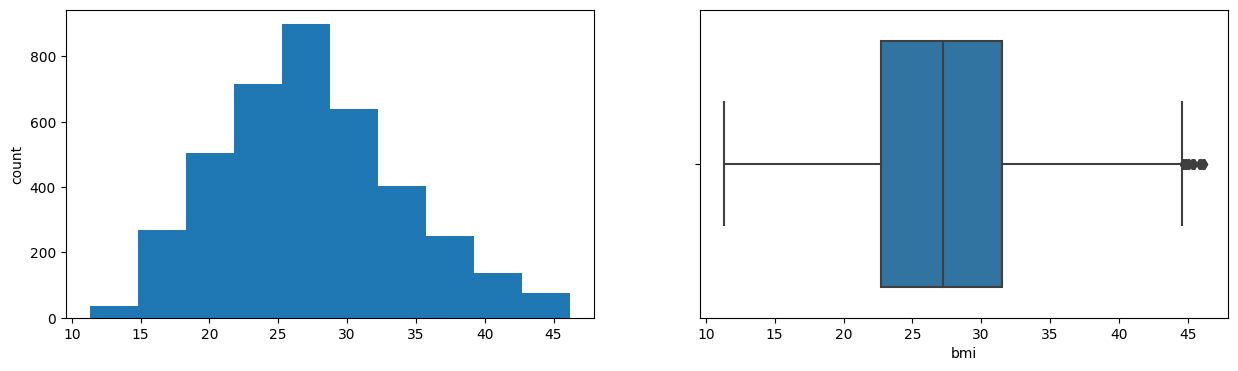

stroke
Skew:  5.67


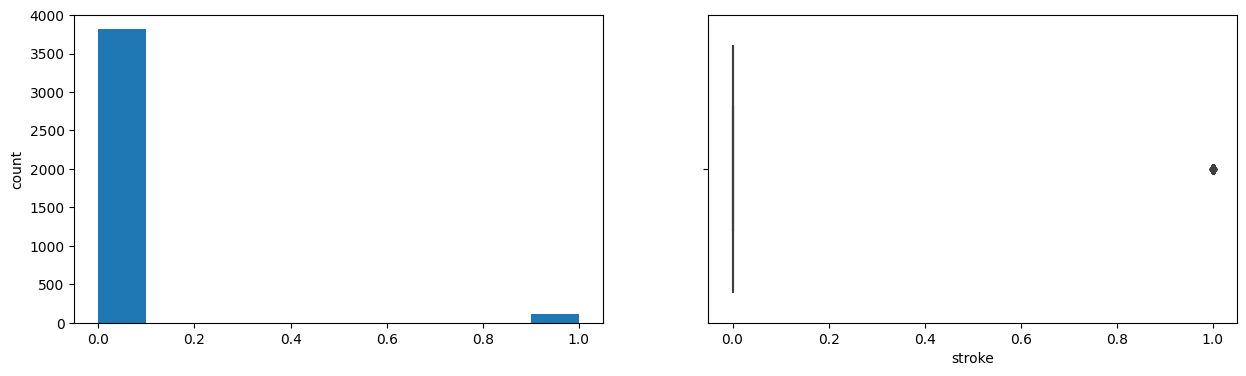

In [13]:
cat_cols=df.select_dtypes(include=['object']).columns
num_cols=df.select_dtypes(include=np.number).columns.tolist()
print('Categorical variables:')
print(cat_cols)
print('Numerical variables:')
print(num_cols)

for col in num_cols:
    print(col)
    print('Skew: ', round(df[col].skew(),2))
    plt.figure(figsize = (15,4))
    plt.subplot(1,2,1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.show()

In [14]:
skewness_after_outlier_removal = df[numerical_cols].skew()
print(skewness_after_outlier_removal)

# Apply log transformation to columns with positive skew (>0.5)
for column in df[numerical_cols].select_dtypes(include=['float64', 'int64']).columns:
    if skewness_after_outlier_removal[column] > 0.5:  # Positive skew
        df[numerical_cols] = df[numerical_cols].apply(lambda x: np.log(x + 1))  # Log transformation (avoid log(0))

# Recalculate skewness after log transformation
skewness_after_log = df[numerical_cols].skew()
print("\nSkewness after log transformation:")
print(skewness_after_log)

id                  -0.026766
age                  0.087979
hypertension         0.000000
heart_disease        0.000000
avg_glucose_level    0.856036
bmi                  0.362704
dtype: float64

Skewness after log transformation:
id                  -1.902448
age                 -1.449416
hypertension         0.000000
heart_disease        0.000000
avg_glucose_level    0.259357
bmi                 -0.218424
dtype: float64


In [15]:
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)
df = df.astype(int)
df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
7,9,4,0,0,4,3,1,0,0,0,0,1,0,0,1,0,1,0
8,10,4,0,0,4,3,1,0,0,1,0,1,0,0,0,0,0,0
9,11,4,0,0,4,3,1,0,0,1,0,1,0,0,1,0,0,0
12,9,4,0,0,4,3,1,0,0,1,0,1,0,0,1,0,0,1
18,10,4,0,0,4,3,1,0,0,0,0,1,0,0,1,0,1,0


In [16]:
print(df.columns)

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')


In [17]:
# Check the distribution of the target variable 'stroke'
print("Class distribution in target variable 'stroke':")
print(df['stroke'].value_counts())

Class distribution in target variable 'stroke':
stroke
0    3814
1     112
Name: count, dtype: int64


In [18]:
# Check the first few rows to confirm data integrity
print(df['stroke'].head())

# Check the unique values in the 'stroke' column to ensure both classes exist
print(df['stroke'].unique())

7     1
8     1
9     1
12    1
18    1
Name: stroke, dtype: int64
[1 0]


In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Separate features and target
X = df.drop('stroke', axis=1)  # Features
y = df['stroke']  # Target

# Check the class distribution before applying SMOTE
print("Class distribution before SMOTE:", Counter(y))

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Check the class distribution after applying SMOTE
print("\nClass distribution after SMOTE:", Counter(y_res))

Class distribution before SMOTE: Counter({0: 3814, 1: 112})

Class distribution after SMOTE: Counter({1: 3814, 0: 3814})


In [20]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)

# Check the scaled features (first 5 rows)
print(X_res_scaled[:5])

[[-0.57358259  0.7734885   0.          0.         -0.12151761  0.24890125
  -0.72035878 -0.01145047 -1.5677507  -0.05378153  0.85560608 -0.44100787
  -0.31208342  1.00710442 -0.48157257  1.48857368 -0.37239417]
 [ 0.33264939  0.7734885   0.          0.         -0.12151761  0.24890125
  -0.72035878 -0.01145047  0.63785652 -0.05378153  0.85560608 -0.44100787
  -0.31208342 -0.9929457  -0.48157257 -0.67178401 -0.37239417]
 [ 1.23888137  0.7734885   0.          0.         -0.12151761  0.24890125
  -0.72035878 -0.01145047  0.63785652 -0.05378153  0.85560608 -0.44100787
  -0.31208342  1.00710442 -0.48157257 -0.67178401 -0.37239417]
 [-0.57358259  0.7734885   0.          0.         -0.12151761  0.24890125
  -0.72035878 -0.01145047  0.63785652 -0.05378153  0.85560608 -0.44100787
  -0.31208342  1.00710442 -0.48157257 -0.67178401  2.68532671]
 [ 0.33264939  0.7734885   0.          0.         -0.12151761  0.24890125
  -0.72035878 -0.01145047 -1.5677507  -0.05378153  0.85560608 -0.44100787
  -0.312

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_res_scaled, y_res, test_size=0.2, random_state=42)

# Check the size of the split data
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (6102, 17)
Test set size: (1526, 17)


# Model design and Implementation

## 1.randomforestclassifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8905635648754915

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       766
           1       0.85      0.96      0.90       760

    accuracy                           0.89      1526
   macro avg       0.90      0.89      0.89      1526
weighted avg       0.90      0.89      0.89      1526

Confusion Matrix:
 [[633 133]
 [ 34 726]]


## 2. Precptron

In [24]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score

model_perceptron = Perceptron(random_state=42)
model_perceptron.fit(X_train, y_train)

Perceptron(random_state=42)

In [25]:
y_pred_perceptron = model_perceptron.predict(X_test)
print("Perceptron Model - Accuracy:", accuracy_score(y_test, y_pred_perceptron))
print(classification_report(y_test, y_pred_perceptron))
print("Confusion Matrix:\n", confusion_matrix(y_test,  y_pred_perceptron))

Perceptron Model - Accuracy: 0.6579292267365662
              precision    recall  f1-score   support

           0       0.71      0.55      0.62       766
           1       0.63      0.77      0.69       760

    accuracy                           0.66      1526
   macro avg       0.67      0.66      0.65      1526
weighted avg       0.67      0.66      0.65      1526

Confusion Matrix:
 [[419 347]
 [175 585]]


## 3. MLPClassifier

In [26]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*ConvergenceWarning.*")

model_mlp = MLPClassifier(random_state=42, max_iter=2000, tol=1e-5)

model_mlp.fit(X_train, y_train)

MLPClassifier(max_iter=2000, random_state=42, tol=1e-05)

In [27]:
y_pred_mlp = model_mlp.predict(X_test)
print("MLP Model - Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_test,  y_pred_mlp))

MLP Model - Accuracy: 0.8866317169069463
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       766
           1       0.85      0.94      0.89       760

    accuracy                           0.89      1526
   macro avg       0.89      0.89      0.89      1526
weighted avg       0.89      0.89      0.89      1526

Confusion Matrix:
 [[640 126]
 [ 47 713]]


## 4. SVM-RBF

In [28]:
from sklearn.svm import SVC

model_rbf = SVC(kernel='rbf', random_state=42)
model_rbf.fit(X_train, y_train)

SVC(random_state=42)

In [29]:
y_pred_rbf = model_rbf.predict(X_test)
print("SVM with RBF Kernel - Accuracy:", accuracy_score(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rbf))

SVM with RBF Kernel - Accuracy: 0.8348623853211009
              precision    recall  f1-score   support

           0       0.89      0.77      0.82       766
           1       0.79      0.90      0.84       760

    accuracy                           0.83      1526
   macro avg       0.84      0.84      0.83      1526
weighted avg       0.84      0.83      0.83      1526

Confusion Matrix:
 [[589 177]
 [ 75 685]]


## SOM

In [30]:
pip install MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=5b3b93979baf160c4acbb87c5005bf53cb83d055058f8bb5360a1f6235fd9745
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built MiniSom
Note: you may need to restart the kernel to use updated packages.


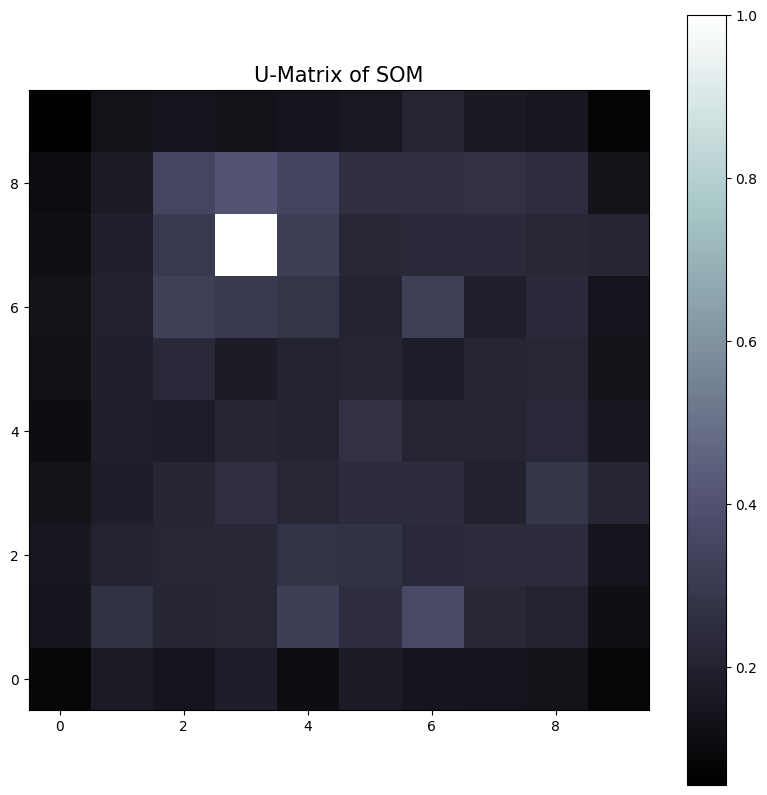

In [31]:
from minisom import MiniSom

# Create and train the SOM
# Create and train the SOM
som = MiniSom(x=10, y=10, input_len=X_train.shape[1], sigma=1.0, learning_rate=0.5)
som.train(X_train, 100)  # Train SOM with 100 iterations

# Visualize the U-Matrix (Unified Distance Matrix) using matplotlib
plt.figure(figsize=(10, 10))
plt.title('U-Matrix of SOM', fontsize=15)

# Plot the U-Matrix (distance between the units in the SOM grid)
plt.imshow(som.distance_map().T, cmap='bone', origin='lower')
plt.colorbar()
plt.show()

# Hyperparameter Tunning

## 1.Randomforest

In [32]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf, n_iter=10, cv=3)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [10, 20, 30],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]})

In [33]:
print("Best parameters for Random Forest:", random_search_rf.best_params_)

best_rf_model = random_search_rf.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the tuned model
print("Random Forest (Tuned) - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest (Tuned) - Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Formest(tunned)- Confusion Martix : ",confusion_matrix(y_test, y_pred_rf))

y_pred_rf_default = model.predict(X_test)
print("Random Forest (Default) - Accuracy:", accuracy_score(y_test, y_pred_rf_default))

Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}
Random Forest (Tuned) - Accuracy: 0.8905635648754915
Random Forest (Tuned) - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       766
           1       0.85      0.96      0.90       760

    accuracy                           0.89      1526
   macro avg       0.90      0.89      0.89      1526
weighted avg       0.90      0.89      0.89      1526

Random Formest(tunned)- Confusion Martix :  [[633 133]
 [ 34 726]]
Random Forest (Default) - Accuracy: 0.8905635648754915


## 2. Precptron

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid_perceptron = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength
    'max_iter': [100, 200, 500],  # Maximum number of iterations
    'penalty': ['l1', 'l2', None],  # Type of regularization
    'eta0': [0.001, 0.01, 0.1],  # Initial learning rate
    'tol': [1e-3, 1e-4, 1e-5]  # Tolerance for stopping criterion
}

# Apply GridSearchCV for hyperparameter tuning
grid_search_perceptron = GridSearchCV(estimator=model_perceptron, param_grid=param_grid_perceptron, cv=3, n_jobs=-1)

# Fit the grid search model
grid_search_perceptron.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Perceptron(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'eta0': [0.001, 0.01, 0.1],
                         'max_iter': [100, 200, 500],
                         'penalty': ['l1', 'l2', None],
                         'tol': [0.001, 0.0001, 1e-05]})

In [35]:
# Get the best parameters from the grid search
print("Best Parameters for Perceptron:", grid_search_perceptron.best_params_)

best_model_perceptron = grid_search_perceptron.best_estimator_
y_pred_perceptron = best_model_perceptron.predict(X_test)

print("Perceptron (Tuned) - Accuracy:", accuracy_score(y_test, y_pred_perceptron))
print("Perceptron (Tuned) - Classification Report:")
print(classification_report(y_test, y_pred_perceptron))
print("Perceptron (Tuned) - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_perceptron))


Best Parameters for Perceptron: {'alpha': 0.01, 'eta0': 0.01, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.0001}
Perceptron (Tuned) - Accuracy: 0.7083879423328965
Perceptron (Tuned) - Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.88      0.75       766
           1       0.82      0.53      0.65       760

    accuracy                           0.71      1526
   macro avg       0.74      0.71      0.70      1526
weighted avg       0.74      0.71      0.70      1526

Perceptron (Tuned) - Confusion Matrix:
[[676  90]
 [355 405]]


## 3. MLPclassiier

In [36]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

model_mlp = MLPClassifier(random_state=42)
random_search = RandomizedSearchCV(model_mlp, param_distributions=param_grid, n_iter=10, cv=3)
random_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

RandomizedSearchCV(cv=3, estimator=MLPClassifier(random_state=42),
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (150,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam', 'sgd']})

In [37]:
print("Best parameters found: ", random_search.best_params_)

best_model_mlp = random_search.best_estimator_

y_pred_mlp = best_model_mlp.predict(X_test)

print("MLP - Accuracy (After Hyperparameter Tuning):", accuracy_score(y_test, y_pred_mlp))
print("MLP - Classification Report (After Hyperparameter Tuning):", classification_report(y_test, y_pred_mlp))
print("MLP - Confusion_matrix (After Hyperparameter Tuning):", confusion_matrix(y_test, y_pred_mlp))


Best parameters found:  {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'activation': 'relu'}
MLP - Accuracy (After Hyperparameter Tuning): 0.8774574049803407
MLP - Classification Report (After Hyperparameter Tuning):               precision    recall  f1-score   support

           0       0.93      0.82      0.87       766
           1       0.84      0.93      0.88       760

    accuracy                           0.88      1526
   macro avg       0.88      0.88      0.88      1526
weighted avg       0.88      0.88      0.88      1526

MLP - Confusion_matrix (After Hyperparameter Tuning): [[629 137]
 [ 50 710]]


## 4. SVC

In [38]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01],  # Kernel coefficient
    'kernel': ['rbf']  # RBF kernel
}

grid_search_svm = GridSearchCV(estimator=model_rbf, param_grid=param_grid_svm, cv=3, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['rbf']})

In [39]:
print("Best Parameters for SVM with RBF Kernel:", grid_search_svm.best_params_)
print("Best Cross-validation Score for SVM with RBF Kernel:", grid_search_svm.best_score_)

best_model_svm = grid_search_svm.best_estimator_
y_pred_svm = best_model_svm.predict(X_test)

print("SVM with RBF Kernel - Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

Best Parameters for SVM with RBF Kernel: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-validation Score for SVM with RBF Kernel: 0.8774172402490986
SVM with RBF Kernel - Accuracy: 0.8748361730013107
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       766
           1       0.83      0.95      0.88       760

    accuracy                           0.87      1526
   macro avg       0.88      0.88      0.87      1526
weighted avg       0.88      0.87      0.87      1526

Confusion Matrix:
 [[614 152]
 [ 39 721]]


# Overfitting and uderfitting concern

## Training and test accuracy

In [40]:
# Check training and test accuracy for Perceptron
train_accuracy_perceptron = best_model_perceptron.score(X_train, y_train)
test_accuracy_perceptron = best_model_perceptron.score(X_test, y_test)

print(f"Perceptron (Tuned) - Train Accuracy: {train_accuracy_perceptron}, Test Accuracy: {test_accuracy_perceptron}")

# Check training and test accuracy for MLP
train_accuracy_mlp = best_model_mlp.score(X_train, y_train)
test_accuracy_mlp = best_model_mlp.score(X_test, y_test)

print(f"MLP (Tuned) - Train Accuracy: {train_accuracy_mlp}, Test Accuracy: {test_accuracy_mlp}")

# Check training and test accuracy for Random Forest
train_accuracy_rf = best_rf_model.score(X_train, y_train)
test_accuracy_rf = best_rf_model.score(X_test, y_test)

print(f"Random Forest (Tuned) - Train Accuracy: {train_accuracy_rf}, Test Accuracy: {test_accuracy_rf}")

# Check training and test accuracy for SVM
train_accuracy_svm = best_model_svm.score(X_train, y_train)
test_accuracy_svm = best_model_svm.score(X_test, y_test)

print(f"SVM with RBF Kernel (Tuned) - Train Accuracy: {train_accuracy_svm}, Test Accuracy: {test_accuracy_svm}")

# Overfitting: If train accuracy is much higher than test accuracy, the model may be overfitting.
# Underfitting: If both are low, the model may be underfitting.

Perceptron (Tuned) - Train Accuracy: 0.7043592264831203, Test Accuracy: 0.7083879423328965
MLP (Tuned) - Train Accuracy: 0.8944608325139298, Test Accuracy: 0.8774574049803407
Random Forest (Tuned) - Train Accuracy: 0.9015077023926581, Test Accuracy: 0.8905635648754915
SVM with RBF Kernel (Tuned) - Train Accuracy: 0.8936414290396592, Test Accuracy: 0.8748361730013107


## Cofusion matrix and classification report for tunned models

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

# Perceptron (Tuned)
print("Perceptron (Tuned) - Classification Report:")
print(classification_report(y_test, best_model_perceptron.predict(X_test)))
print("Perceptron (Tuned) - Confusion Matrix:")
print(confusion_matrix(y_test, best_model_perceptron.predict(X_test)))

# MLP (Tuned)
print("MLP (Tuned) - Classification Report:")
print(classification_report(y_test, best_model_mlp.predict(X_test)))
print("MLP (Tuned) - Confusion Matrix:")
print(confusion_matrix(y_test, best_model_mlp.predict(X_test)))

# Random Forest (Tuned)
print("Random Forest (Tuned) - Classification Report:")
print(classification_report(y_test, best_rf_model.predict(X_test)))
print("Random Forest (Tuned) - Confusion Matrix:")
print(confusion_matrix(y_test, best_rf_model.predict(X_test)))

# SVM with RBF Kernel (Tuned)
print("SVM with RBF Kernel (Tuned) - Classification Report:")
print(classification_report(y_test, best_model_svm.predict(X_test)))
print("SVM with RBF Kernel (Tuned) - Confusion Matrix:")
print(confusion_matrix(y_test, best_model_svm.predict(X_test)))


Perceptron (Tuned) - Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.88      0.75       766
           1       0.82      0.53      0.65       760

    accuracy                           0.71      1526
   macro avg       0.74      0.71      0.70      1526
weighted avg       0.74      0.71      0.70      1526

Perceptron (Tuned) - Confusion Matrix:
[[676  90]
 [355 405]]
MLP (Tuned) - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       766
           1       0.84      0.93      0.88       760

    accuracy                           0.88      1526
   macro avg       0.88      0.88      0.88      1526
weighted avg       0.88      0.88      0.88      1526

MLP (Tuned) - Confusion Matrix:
[[629 137]
 [ 50 710]]
Random Forest (Tuned) - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88   

## Cross-validation

In [42]:
from sklearn.model_selection import cross_val_score

# Cross-validation for Perceptron (Tuned)
cv_scores_perceptron = cross_val_score(best_model_perceptron, X_train, y_train, cv=5)
print(f"Perceptron (Tuned) - Cross-validation scores: {cv_scores_perceptron.mean()}")

# Cross-validation for MLP (Tuned)
cv_scores_mlp = cross_val_score(best_model_mlp, X_train, y_train, cv=5)
print(f"MLP (Tuned) - Cross-validation scores: {cv_scores_mlp.mean()}")

# Cross-validation for Random Forest (Tuned)
cv_scores_rf = cross_val_score(best_rf_model, X_train, y_train, cv=5)
print(f"Random Forest (Tuned) - Cross-validation scores: {cv_scores_rf.mean()}")

# Cross-validation for SVM with RBF Kernel (Tuned)
cv_scores_svm = cross_val_score(best_model_svm, X_train, y_train, cv=5)
print(f"SVM with RBF Kernel (Tuned) - Cross-validation scores: {cv_scores_svm.mean()}")


Perceptron (Tuned) - Cross-validation scores: 0.6701092896174863


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP (Tuned) - Cross-validation scores: 0.8784030826653778
Random Forest (Tuned) - Cross-validation scores: 0.8890557323344208
SVM with RBF Kernel (Tuned) - Cross-validation scores: 0.8769284784038882


## Learning curves

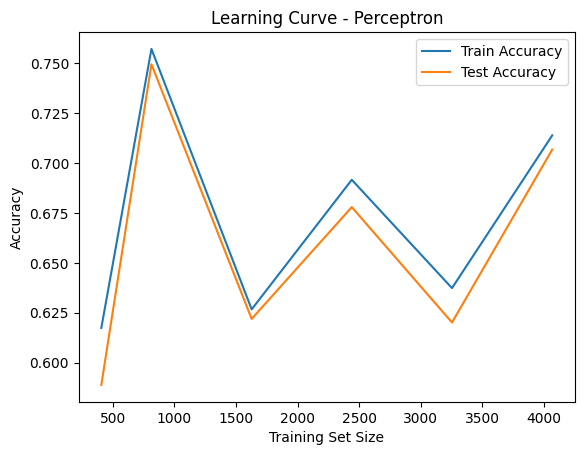

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

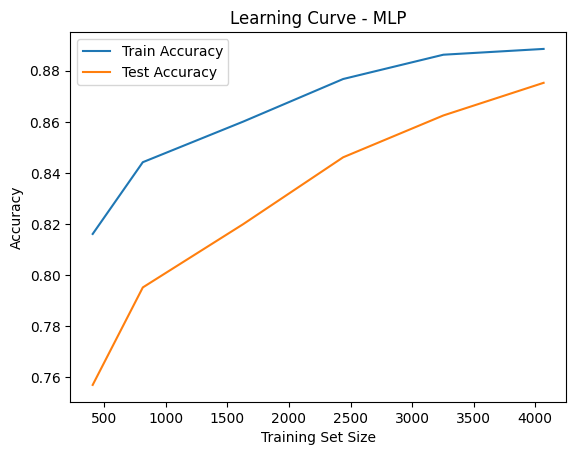

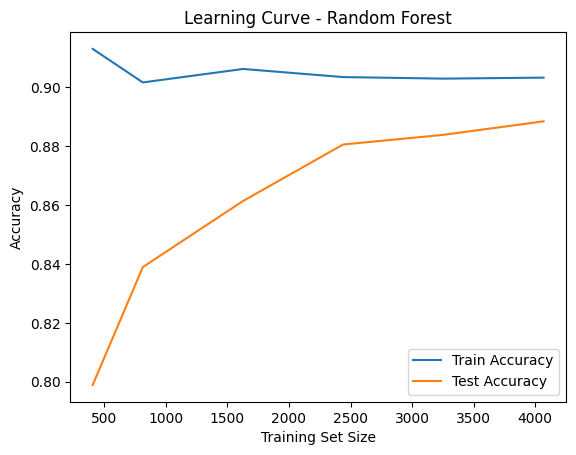

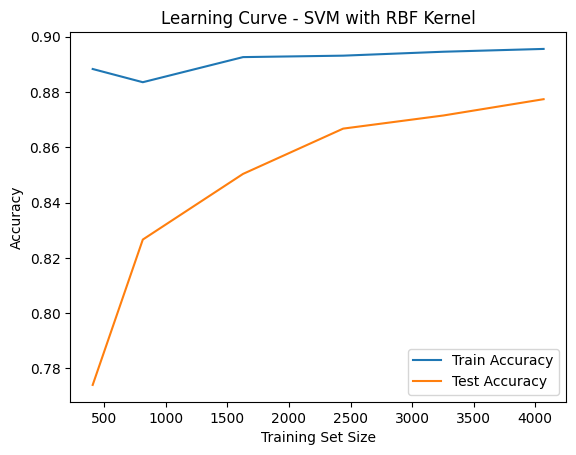

In [43]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Learning curve for Perceptron (Tuned)
train_sizes_perceptron, train_scores_perceptron, test_scores_perceptron = learning_curve(
    best_model_perceptron, X_train, y_train, cv=3, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
)

# Plotting the learning curve for Perceptron
plt.plot(train_sizes_perceptron, train_scores_perceptron.mean(axis=1), label='Train Accuracy')
plt.plot(train_sizes_perceptron, test_scores_perceptron.mean(axis=1), label='Test Accuracy')
plt.title('Learning Curve - Perceptron')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Learning curve for MLP (Tuned)
train_sizes_mlp, train_scores_mlp, test_scores_mlp = learning_curve(
    best_model_mlp, X_train, y_train, cv=3, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
)

# Plotting the learning curve for MLP
plt.plot(train_sizes_mlp, train_scores_mlp.mean(axis=1), label='Train Accuracy')
plt.plot(train_sizes_mlp, test_scores_mlp.mean(axis=1), label='Test Accuracy')
plt.title('Learning Curve - MLP')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Similarly, plot for Random Forest and SVM with RBF Kernel

# Learning curve for Random Forest (Tuned)
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    best_rf_model, X_train, y_train, cv=3, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
)

# Plotting the learning curve for Random Forest
plt.plot(train_sizes_rf, train_scores_rf.mean(axis=1), label='Train Accuracy')
plt.plot(train_sizes_rf, test_scores_rf.mean(axis=1), label='Test Accuracy')
plt.title('Learning Curve - Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Learning curve for SVM with RBF Kernel (Tuned)
train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(
    best_model_svm, X_train, y_train, cv=3, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
)

# Plotting the learning curve for SVM with RBF Kernel
plt.plot(train_sizes_svm, train_scores_svm.mean(axis=1), label='Train Accuracy')
plt.plot(train_sizes_svm, test_scores_svm.mean(axis=1), label='Test Accuracy')
plt.title('Learning Curve - SVM with RBF Kernel')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


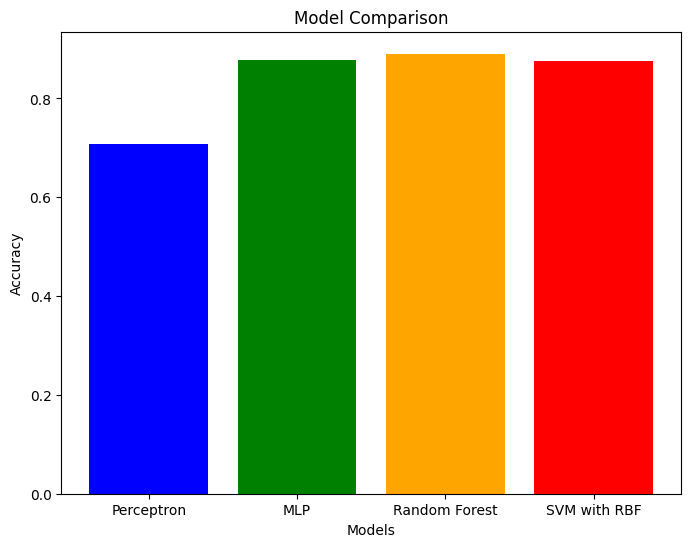

In [44]:
# Assuming you have the predicted values for each model
accuracy_perceptron = accuracy_score(y_test, y_pred_perceptron)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# List of models and their corresponding accuracies
models = ['Perceptron', 'MLP', 'Random Forest', 'SVM with RBF']
accuracies = [accuracy_perceptron, accuracy_mlp, accuracy_rf, accuracy_svm]

# Create a bar chart for model comparison
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()


This notebook focuses on predicting the likelihood of stroke using various machine learning algorithms.
We perform:

**Data preprocessing:** handling missing values, encoding categorical features, scaling numerical values.

**Exploratory Data Analysis (EDA):** understanding feature distributions and correlations.

**Model training & comparison:** Logistic Regression, Random Forest, Decision Tree, SVM, and more.

**Performance evaluation:** accuracy, precision, recall, F1-score, and confusion matrix comparison.

The goal is to determine the best-performing model for stroke prediction based on evaluation metrics.